# Papers Past Genre Classification
# Notebook 7: Multiclass Classification with combined genre classes
---

This notebook trains and evaluates a number of classification models and feature sets using a multiclass classification approach where each genre is encoded with a number. In this notebook 'similar' genres are combined at the label encoding stage. The loaded dataset is the output of Notebook 3: Linguistic Feature Extraction. A dataframe of the metrics for all combinations is returned and exported as a csv file for further analysis.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Metrics/Evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from scipy import interp
from itertools import cycle

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from datetime import date
from datetime import datetime

In [2]:
filepath = '20220113_PP_3518articles_withfeatures.pkl'
features_df = pd.read_pickle(filepath)

In [3]:
len(features_df)

3518

In [4]:
# View the distribution of the genres
(features_df['genre'].value_counts() / len(features_df)).sort_values(ascending=False)

Report            0.284537
News              0.163729
Notice            0.162308
Opinion           0.138999
Feature           0.048891
LetterToEditor    0.047754
Results           0.041217
FamilyNotice      0.029278
Fiction           0.020182
Advertisement     0.018761
Review            0.018476
Poetry            0.009665
Obituary          0.009096
Speech            0.007106
Name: genre, dtype: float64

In [5]:
# Refining the genre groups

# Remove advertisements
features_df = features_df[features_df.genre != "Advertisement"]
len(features_df)

3452

In [6]:
# Combining the genre groups

# Assign numeric labels - giving the same label to genres in the same group
label_groups = [
    (features_df['genre'] == "FamilyNotice"),   # 1
    (features_df['genre'] == "LetterToEditor"), # 2
    (features_df['genre'] == "Feature"),        # 3
    (features_df['genre'] == "Fiction"),        # 4
    (features_df['genre'] == "News"),           # 3
    (features_df['genre'] == "Notice"),         # 5
    (features_df['genre'] == "Obituary"),       # 3
    (features_df['genre'] == "Opinion"),        # 2
    (features_df['genre'] == "Poetry"),         # 6
    (features_df['genre'] == "Report"),         # 3
    (features_df['genre'] == "Results"),        # 3
    (features_df['genre'] == "Review"),         # 2
    (features_df['genre'] == "Speech"),         # 2
    ]

# List of the values to assign for each genre group 
# Must be in the same order as the respective genres in 'label_groups'
values = [1, 2, 3, 4, 3, 5, 3, 2, 6, 3, 3, 2, 2]

# Create a new column and use np.select to assign label number
features_df["label_num"] = np.select(label_groups, values)

# Display updated Dataframe
features_df.head()

,date,newspaper_id,newspaper,article_id,avg_line_width,min_line_width,max_line_width,line_width_range,avg_line_offset,max_line_offset,...,cc_freq,nnp_freq,vbd_freq,vbz_freq,polysyll_freq,monosyll_freq,stopword_freq,tf_idf,tf_idf_sum,label_num
0,1878-10-26,KUMAT,Kumara Times,1,452.272727,282.0,512.0,230.0,33.090909,174.0,...,0.052632,0.403509,0.000000,0.000000,0.122807,0.614035,0.263158,"{'30p': 0.2663854421079567, 'cisco': 0.2266298...",1.124314,5
1,1878-10-26,KUMAT,Kumara Times,3,429.500000,95.0,515.0,420.0,22.000000,104.0,...,0.000000,0.369565,0.043478,0.043478,0.108696,0.652174,0.217391,"{'bails': 0.2553070426931307, 'westpobt': 0.27...",1.328593,1
2,1878-10-26,KUMAT,Kumara Times,4,469.765854,64.0,589.0,525.0,22.575610,378.0,...,0.019452,0.288240,0.045093,0.005305,0.091954,0.702034,0.297966,"{'to': 0.20579354224228943, 'the': 0.440539728...",1.133181,3
3,1878-10-26,KUMAT,Kumara Times,5,480.044444,109.0,599.0,490.0,18.183333,244.0,...,0.034291,0.240037,0.046339,0.025023,0.095459,0.689527,0.342910,"{'the': 0.3078061382699132, 'of': 0.2239935499...",1.048271,3
4,1878-10-26,KUMAT,Kumara Times,6,461.769231,51.0,531.0,480.0,22.745562,363.0,...,0.022052,0.236817,0.051774,0.001918,0.110259,0.681687,0.357622,"{'to': 0.24361741360382583, 'bill': 0.28737846...",1.377992,3


In [7]:
# View the distribution of the genres
(features_df['label_num'].value_counts() / len(features_df)).sort_values(ascending=False)

3    0.557937
2    0.216396
5    0.165411
1    0.029838
4    0.020568
6    0.009849
Name: label_num, dtype: float64

In [8]:
# Dictionary of feature groups
feature_dict = {'pos_freq_penn': ["nnps_freq", "vb_freq", "nn_freq", 
                                   "jj_freq", "cd_freq", "prp_freq", 
                                   "rb_freq", "cc_freq", "nnp_freq", 
                                   "vbd_freq", "vbz_freq", "stopword_freq"],
                'pos_freq_univ': ["propn_freq", "verb_freq", "noun_freq", 
                                   "adj_freq", "nums_freq", "pron_freq", 
                                   "stopword_freq"],
                'pos_freq_combo': ["nnps_freq", "vb_freq", "nn_freq", 
                                    "jj_freq", "cd_freq", "prp_freq", 
                                    "rb_freq", "cc_freq", "nnp_freq", "vbd_freq", 
                                    "vbz_freq", "propn_freq", "verb_freq", "noun_freq", 
                                    "adj_freq", "nums_freq", "pron_freq", "stopword_freq"],
                'line_offsets': ["avg_line_offset", "max_line_offset"],
                'line_widths': ["avg_line_width", "min_line_width", 
                                "max_line_width", "line_width_range"],
                'syllable_freq': ["polysyll_freq", "monosyll_freq"],
                'tf_idf': ["tf_idf_sum"],
                'text_stats': ["sentence_count", "word_count", 
                               "avg_word_length", "char_count"],
                'all_features': ["propn_freq", "verb_freq", "noun_freq", 
                                 "adj_freq", "nums_freq", "pron_freq", 
                                 "nnps_freq", "vb_freq", "nn_freq", "jj_freq", 
                                 "cd_freq", "prp_freq", "rb_freq", "cc_freq", 
                                 "nnp_freq", "vbd_freq", "vbz_freq", "stopword_freq", 
                                 "avg_line_offset", "max_line_offset", "avg_line_width", 
                                 "min_line_width", "max_line_width", "line_width_range", 
                                 "polysyll_freq", "monosyll_freq", "sentence_count", "word_count", 
                                 "avg_word_length", "char_count", "tf_idf_sum"],
                'all_features_excl_penn': ["propn_freq", "verb_freq", "noun_freq", 
                                           "adj_freq", "nums_freq", "pron_freq", 
                                           "stopword_freq", "avg_line_offset", 
                                           "max_line_offset", "avg_line_width", 
                                           "min_line_width", "max_line_width", 
                                           "line_width_range", "polysyll_freq", 
                                           "monosyll_freq", "sentence_count", "word_count", 
                                           "avg_word_length", "char_count", "tf_idf_sum"],
                'all_features_excl_univ': ["nnps_freq", "vb_freq", "nn_freq", "jj_freq", 
                                           "cd_freq", "prp_freq", "rb_freq", "cc_freq", 
                                           "nnp_freq", "vbd_freq", "vbz_freq", "stopword_freq", 
                                           "avg_line_offset", "max_line_offset", "avg_line_width", 
                                           "min_line_width", "max_line_width", "line_width_range", 
                                           "polysyll_freq", "monosyll_freq", "sentence_count", "word_count", 
                                           "avg_word_length", "char_count", "tf_idf_sum"],
                'all_features_excl_tfidf': ["nnps_freq", "vb_freq", "nn_freq", "jj_freq", 
                                            "cd_freq", "prp_freq", "rb_freq", "cc_freq", 
                                            "nnp_freq", "vbd_freq", "vbz_freq", "stopword_freq", 
                                            "avg_line_offset", "max_line_offset", "avg_line_width", 
                                            "min_line_width", "max_line_width", "line_width_range", 
                                            "polysyll_freq", "monosyll_freq", "sentence_count", 
                                            "word_count", "avg_word_length", "char_count"]
               }

In [9]:
# Dictionary of models
model_dict = {'Dummy' : DummyClassifier(random_state=3),
              'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decision Tree': DecisionTreeClassifier(random_state=3),
              'AdaBoost': AdaBoostClassifier(random_state=3),
              'GradientBoosting': GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=3),
              'Gaussian Naive Bayes': GaussianNB(),
              'K Nearest Neighbor': KNeighborsClassifier(), 
              'Support Vector Machine': SVC(kernel='rbf', random_state=3)}

In [10]:
# Preliminary model evaluation using default parameters
# Code reference: https://medium.com/@robert.salgado/multiclass-text-classification-from-start-to-finish-f616a8642538

# Function to get the scores for each model in a df
def model_score_df(model_dict, X_train, X_test, y_train, y_test, feature_set):
    """
    Given a dictionary of scikit learn models, 
    return a dataframe of metrics ranked by 
    best F1 score.
    """
    feature_set_list, model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], [], []
    
    for k,v in model_dict.items():   
        feature_set_list.append(feature_set)
        model_name.append(k)
        pipe = make_pipeline(StandardScaler(), v) # data is scaled
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='weighted')) # Setting average = weighted to account for label imbalance
        r_score_list.append(recall_score(y_test, y_pred, average = 'weighted'))
        f1_score_list.append(f1_score(y_test, y_pred, average = 'weighted'))
              
        model_comparison_df = pd.DataFrame([feature_set_list, 
                                            model_name, 
                                            ac_score_list, 
                                            p_score_list, 
                                            r_score_list, 
                                            f1_score_list]).T
        model_comparison_df.columns = ['feature_set',
                                       'model_name', 
                                       'accuracy_score', 
                                       'precision_score', 
                                       'recall_score', 
                                       'f1_score']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    
    return model_comparison_df

In [11]:
def genres_multiclass(df, feature_dict, model_dict):
    """
    Given a list of genres and dictionaries
    of features and models, train and test multiclass classification
    models for each feature set and 
    return the dataframe of metrics.
    """
    dataframes = []
    
    # Append "label_num" to each feature dictionary
    for k, v in feature_dict.items():
        v.append("label_num")
      
        model_df = df.filter(v, axis=1)

        # Extract the explanatory variables in X and the target variable in y
        y = model_df.label_num.copy()
        X = model_df.drop(["label_num"], axis=1)

        #Train test split with stratified sampling for evaluation
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size = .3, 
                                                            shuffle = True, 
                                                            stratify = y, 
                                                            random_state = 3)
        
        model_results = model_score_df(model_dict, X_train, X_test, y_train, y_test, k) 
        dataframes.append(model_results)

        del y, X, model_df, X_train, X_test, y_train, y_test  # Clear the dataframes from memory before next loop
    
    results_df = pd.concat(dataframes)
    
    return results_df
        

In [12]:
results_df = genres_multiclass(features_df, feature_dict, model_dict)

C:\Users\kst103\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kst103\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kst103\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kst103\AppData\Roaming\Pytho

C:\Users\kst103\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kst103\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kst103\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kst103\AppData\Roaming\Pytho

In [13]:
results_df = results_df.sort_values(by='f1_score', ascending=False)
pd.set_option('display.max_rows', None)
display(results_df)

,feature_set,model_name,accuracy_score,precision_score,recall_score,f1_score
8,all_features,Support Vector Machine,0.80695,0.809955,0.80695,0.806193
8,all_features_excl_tfidf,Support Vector Machine,0.799228,0.800599,0.799228,0.797895
8,all_features_excl_univ,Support Vector Machine,0.796332,0.796696,0.796332,0.794422
2,all_features_excl_tfidf,Random Forest,0.789575,0.790212,0.789575,0.785759
2,all_features,Random Forest,0.78668,0.78992,0.78668,0.784387
2,all_features_excl_univ,Random Forest,0.784749,0.785945,0.784749,0.78073
8,all_features_excl_penn,Support Vector Machine,0.781853,0.782576,0.781853,0.78049
7,all_features,K Nearest Neighbor,0.776062,0.784764,0.776062,0.774631
2,pos_freq_combo,Random Forest,0.776062,0.773013,0.776062,0.771702
7,all_features_excl_tfidf,K Nearest Neighbor,0.771236,0.776626,0.771236,0.770559


In [14]:
# Export the dataframe of results to a CSV file 
results_df.to_csv("20220114_PP_3518articles_metrics_multiclass_combinedgenres.csv")

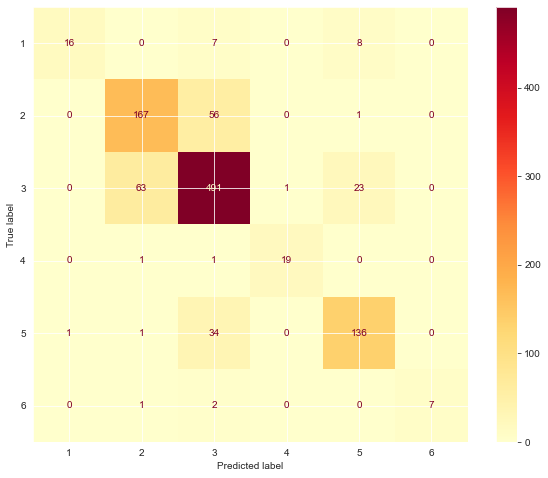

KEY TO GENRE GROUPS:
-----------------------------------------------------------------
1:  Family Notice
2:  Opinion-based = Letter to Editor, Opinion, Review, Speech
3:  Reportage-based = Feature, News, Obituary, Report, Results
4:  Fiction
5:  Notice
6:  Poetry
-----------------------------------------------------------------


In [15]:
# Display confusion matrix for best model (SVM, all_features)

all_features = ["propn_freq", 
                "verb_freq", 
                "noun_freq", 
                "adj_freq", 
                "nums_freq", 
                "pron_freq", 
                "nnps_freq", 
                "vb_freq", 
                "nn_freq", 
                "jj_freq", 
                "cd_freq", 
                "prp_freq", 
                "rb_freq", 
                "cc_freq", 
                "nnp_freq", 
                "vbd_freq", 
                "vbz_freq", 
                "stopword_freq", 
                "avg_line_offset", 
                "max_line_offset", 
                "avg_line_width", 
                "min_line_width", 
                "max_line_width", 
                "line_width_range", 
                "polysyll_freq", 
                "monosyll_freq", 
                "sentence_count", 
                "word_count", 
                "avg_word_length", 
                "char_count", 
                "tf_idf_sum"]

all_features.append("label_num")

best_model_df = features_df.filter(all_features, axis=1)

# Extract the explanatory variables in X and the target variable in y
y = best_model_df.label_num.copy()
X = best_model_df.drop(["label_num"], axis=1)

#Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .3, 
                                                    shuffle = True, 
                                                    stratify = y, 
                                                    random_state = 3)


pipe = make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=3)) # data is scaled
pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)  
    
cm = confusion_matrix(y_test, predictions, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
plt.rcParams["figure.figsize"] = (10,8)
disp.plot(cmap = "YlOrRd")
# plt.savefig('multiclass_conf.svg')
plt.show()

print("KEY TO GENRE GROUPS:")
print("-----------------------------------------------------------------")
print("1:  Family Notice")
print("2:  Opinion-based = Letter to Editor, Opinion, Review, Speech")
print("3:  Reportage-based = Feature, News, Obituary, Report, Results")
print("4:  Fiction")
print("5:  Notice")
print("6:  Poetry")
print("-----------------------------------------------------------------")
